### todo
- need to check that timestamp is monotonically increasing
- derive speech duration from timestamp (after checking and correcting if need be)
- fill missing timestamps by taking time between the next ones, then allocating to ones in between with missing based on word/character count
- [x] check speakers (then maybe exclude "Computer")
- [x] clean "[inaudible]", "[crosstalk]", "[foreign language]", also (*)
- check for special character to see for other things that need to be potentially cleaned


# speech preprocessing

- lowercase everything
- tokenization (words, punctuation)
- parts of speech (noun, verb etc.)
- lemmatization (thought -> think)
- remove stopwords (a, the, etc)
- pointwise mutual information (euro group -> euro_group)

In [1]:
import re

import numpy as np
import pandas as pd

In [2]:
#import nltk
#nltk.download('stopwords')

In [3]:
df = pd.read_csv('data/euroleaks/prepared.csv')
df.head()

,speaker,speech,timestamp,date
0,Jeroen Dijsselbloem,… of your responses or questions. And can I fi...,1900-01-01 00:00:00,2015-02-24 00:00:00
1,Speaker 2,"Uh, yes, uh, thank you, Jeroen. Well, uh, comm...",1900-01-01 00:00:10,2015-02-24 00:00:00
2,Michael Noonan,Michael Noonan.,1900-01-01 00:01:27,2015-02-24 00:00:00
3,Speaker 2,"Uh, it is therefore regrettable that, uh-",1900-01-01 00:01:29,2015-02-24 00:00:00
4,Speaker 3,Has entered the conference.,1900-01-01 00:01:33,2015-02-24 00:00:00


## preliminary cleaning
- make all speech lowercase
- remove "Has entered the conference."
- remove speaker computer

In [ ]:
# lowercase speech
df.speech = df.speech.apply(lambda s: s.lower())

In [4]:
# clean speaker

# strip and make lowercase
df.speaker = df.speaker.apply(lambda s: s.strip().lower() if not pd.isnull(s) else s)

# handle missing (only one)
df.speaker.loc[df.speaker.isnull()] = 'jeroen dijsselbloem'

# drop transcription artifact speaker
df = df[df.speaker != 'group']
df = df[df.speaker != 'inaudible']

# drop comuter generated speech
df = df[df.speech != 'Has entered the conference.']

# make names unique
amend_names = {
    'wolfgang schäuble': [
        'wolfgang schäuble',
        'wolfgang schauble',
        'wolfgang'
    ],
    'peter kažimír': [
        'peter kažimír',
        'peter kazimir'
    ],
    'michel sapin': [
        'michel sapin',
        'michel'
    ],
    'maria luís albuquerque': [
        'maria luís albuquerque',
        'maria luís',
        'maria luis albuquerque'
    ],
    'johan van overtveldt': [
        'johan van overtveldt',
        'johan'
    ],
    'benoît cœuré': [
        'benoît cœuré',
        'benoit couré',
        'benoit cœuré'
    ],
    'hans jörg schelling': [
        'hans jörg schelling',
        'hans'
    ],
    'poul mathias thomsen': [
        'paul thomsen',
        'paul',
        'poul thomsen'
    ],
    'yanis varoufakis': [
        'yanis varoufakis',
        'yanis varoufakis [privately]'
    ],
    'luis de guindos': [
        'luis de guindos',
        'luis'
    ],
    'irina': [
        'irina',
        'irana'
    ],
    'jānis reirs': [
        'yanis [not varoufakis]'
    ],
    'luca antonio ricci': [
        'ricci'
    ],
    'thomas steffen': [
        'thomas'
    ]
}

# invert dict
amend_names_inv = {value: key for key,values in amend_names.items() for value in values}

# amend speaker names
df.speaker = df.speaker.apply(lambda s: amend_names_inv[s] if s in amend_names_inv.keys() else s)

In [5]:
df.head()

,speaker,speech,timestamp,date
0,jeroen dijsselbloem,… of your responses or questions. And can I fi...,1900-01-01 00:00:00,2015-02-24 00:00:00
1,speaker 2,"Uh, yes, uh, thank you, Jeroen. Well, uh, comm...",1900-01-01 00:00:10,2015-02-24 00:00:00
2,michael noonan,Michael Noonan.,1900-01-01 00:01:27,2015-02-24 00:00:00
3,speaker 2,"Uh, it is therefore regrettable that, uh-",1900-01-01 00:01:29,2015-02-24 00:00:00
5,speaker 2,"… that the letter by the Minister does not, uh...",1900-01-01 00:01:37,2015-02-24 00:00:00


## regex: remove paranthesis and brackets
Numbers can be better filtered out using POS (parts of speech).

In [6]:
brackets = []

for s in df.speech:
    pattern = re.compile('\[\w*\]')
    found = pattern.search(s)
    if found:
        brackets.append(found.group())

np.unique(brackets)

array(['[French]', '[Inaudible]', '[]', '[affirmative]', '[bang]',
       '[bonds]', '[crosstalk]', '[in]', '[inaudible]', '[laughs]',
       '[laughter]', '[measures]', '[silence]'], dtype='<U13')

In [7]:
paranthesis = []

for s in df.speech:
    pattern = re.compile('\(.*\)')
    found = pattern.search(s)
    if found:
        paranthesis.append(found.group())

np.unique(paranthesis)

array(['(06:45)', '(07:36)', '(08:14)', '(09:08)', '(13:07)', '(21:35)',
       '(22:25)', '(22:58)', '(29:07)', '(30:57)', '(35:39)',
       '(Crosstalk)', '(affirmative)', '(crosstalk)',
       '(foreign [language)', '(inaudible greetings)', '(inaudible)',
       '(inaudible) and also the [bonds] recapitalization requirements for the new program, so when you combine the two facts {inaudible] this results (crosstalk 12:26)',
       '(laughing)', '(laughs)', '(nse)', '(silence)'], dtype='<U160')

In [8]:
import re

def remove_brackets(sentence):
    brackets_ = re.compile('\[.*\]')
    return re.sub(brackets_, '', sentence)

def remove_paranthesis(sentence):
    paranthesis_ = re.compile('\(.*\)')
    return re.sub(paranthesis_, '', sentence)

In [9]:
df.speech = df.speech.apply(lambda s: remove_brackets(remove_paranthesis(s)))

## the "aide memoire" case
This term proved to be important while investigating bigram collocations.

https://en.wikipedia.org/wiki/Aide-m%C3%A9moire

In [12]:
def aide_memoire(s):
    """Replaces all of:
        'aid memoire'
        'aide memoir'
        'aide memoire'
        'aide -memoire'
        'aide-memoir'
        'aide-memoire'
    with 'aide memoire'.
    """
    pattern = re.compile('(aide{0,1} {0,1}( |-)memoire{0,1})')
    return re.sub(pattern, 'aide memoire', s)

In [13]:
df.speech = df.speech.apply(lambda s: aide_memoire(s))

## combine all speech to a single document

In [14]:
# lower-case everything, combine to single string
raw_doc = ' '.join(df.speech.apply(lambda s: s.lower()))

In [15]:
len(raw_doc)

503686

## tokenization
- https://spacy.io/models

In [16]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [17]:
doc = nlp(raw_doc) # takes a few minutes

In [18]:
tokens = [[ token.text for token in sentence] for sentence in doc.sents]

In [19]:
#tokens[:5]

In [20]:
c = 0
for t in tokens:
    c += len(t)
print(c)

108483


## lemmatization and POS tagging

In [21]:
lemmas = [[token.lemma_ for token in sentence] for sentence in doc.sents]

In [22]:
#lemmas

In [23]:
foo = [[(token.lemma_, token.pos_) for token in sentence] for sentence in doc.sents]

In [24]:
for f in foo[1]:
    print(f)

('and', 'CCONJ')
('can', 'AUX')
('I', 'PRON')
('first', 'ADV')
(',', 'PUNCT')
('first', 'ADV')
('ask', 'VERB')
('the', 'DET')
('commission', 'NOUN')
(',', 'PUNCT')
(' ', 'SPACE')
('or', 'CCONJ')
('pierre', 'NOUN')
(',', 'PUNCT')
('to', 'PART')
('uh', 'INTJ')
(',', 'PUNCT')
('give', 'VERB')
('their', 'PRON')
('headline', 'NOUN')
('.', 'PUNCT')


## stopwords

In [25]:
# make stopwords out of names
stopnames = []

for names in amend_names.values():
    for name in names:
        if not re.search('\[.*\]', name):
            stopnames += name.split(' ')
            
for name in df.speaker.unique():
    if 'speaker' not in name:
        stopnames += name.split(' ')
    
stopnames = set(stopnames)

In [26]:
content = [[token.text for token in sentence if 
            not token.is_stop and
            not token.text in stopnames
           ] for sentence in doc.sents]

In [27]:
c = 0
for t in content:
    c += len(t)
print(c)

52011


In [28]:
#content

## named entities

In [29]:
#entities = [[( entity.text , entity.label_)
#    for entity in nlp(sentence.text).ents]
#    for sentence in doc.sents]

#entities

## numbers
If not important, then either leave out with POS or replace with regex.

In [35]:
import re

numbers = re.compile('[0-9]')
re.sub(numbers , '0', 'Back in the 90s, when I was a 12-year -old ,a CD cost just 15,99 EUR!')

'Back in the 00s, when I was a 00-year -old ,a CD cost just 00,00 EUR!'

## pointwise mutual information (collocations)
- https://www.nltk.org/howto/collocations.html
- mi_like score: https://www.nltk.org/api/nltk.metrics.html#nltk.metrics.association.NgramAssocMeasures.mi_like

In [30]:
def apply_trigram_colloc(s, set_colloc):
    res = s.lower()
    for b1,b2,b3 in set_colloc:
        res = res.replace(f'{b1} {b2} {b3}', f'{b1}_{b2}_{b3}')
    return res

def apply_bigram_colloc(s, set_colloc):
    res = s.lower()
    for b1,b2 in set_colloc:
        res = res.replace(f'{b1} {b2}', f'{b1}_{b2}')
    return res

#### trigrams

In [44]:
from nltk.collocations import TrigramCollocationFinder, TrigramAssocMeasures

# needs to be a one-dim list
# lemmatization, filter out punctuation and stop words
words = [token.lemma_ for sentence in doc.sents for token in sentence
            if token.pos_ in {'ADJ', 'ADV', 'NOUN', 'PROPN', 'VERB'}
            and not token.is_stop
            and not token.text in stopnames
            and len(token) > 1 # for punctuation (but also 'I')
        ]

finder = TrigramCollocationFinder.from_words(words)

# word might be highly correlated but very infrequent, ignore all with less than n occurances
finder.apply_freq_filter(5)

tgm = TrigramAssocMeasures()
collocations = {trigram: pmi for trigram, pmi in finder.score_ngrams(tgm.mi_like)}

In [45]:
collocations

{('euro', 'working', 'group'): 0.045454545454545456,
 ('comprehensive', 'valid', 'starting'): 0.027233115468409588,
 ('successful', 'conclusion', 'review'): 0.011784511784511785,
 ('low', 'interest', 'rate'): 0.010439612699499706,
 ('debt', 'sustainability', 'analysis'): 0.006432858214553638,
 ('valid', 'starting', 'point'): 0.006118453255017132,
 ('statement', '20th', 'february'): 0.005505095625703131,
 ('nominal', 'interest', 'rate'): 0.0030303030303030303,
 ('interest', 'rate', 'environment'): 0.0017536475869809204,
 ('list', 'prior', 'action'): 0.0015639581657280772,
 ('labor', 'market', 'reform'): 0.0015536554593193752,
 ('starting', 'point', 'successful'): 0.001529613313754283,
 ('staff', 'level', 'agreement'): 0.0012303485987696513,
 ('product', 'market', 'reform'): 0.0010193295077016006,
 ('set', 'prior', 'action'): 0.0009186602870813397,
 ('prior', 'action', 'list'): 0.00046339501206757845,
 ('discussion', 'brussel', 'group'): 0.0004310344827586207,
 ('low', 'low', 'pension'):

In [46]:
trigram_colloc = {('euro', 'working', 'group')}

words = apply_trigram_colloc(' '.join(words), trigram_colloc).split(' ')

#### bigrams

In [47]:
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures
#from nltk.corpus import stopwords

#stopwords_ = set(stopwords.words('english'))

finder = BigramCollocationFinder.from_words(words)

# word might be highly correlated but very infrequent, ignore all with less than n occurances
finder.apply_freq_filter(5)

bgm = BigramAssocMeasures()
collocations = {bigram: pmi for bigram, pmi in finder.score_ngrams(bgm.mi_like)}

In [52]:
#collocations

In [49]:
threshold = 1

bigram_colloc_candidate = []
for bigram, score in collocations.items():
    if score > threshold:
        bigram_colloc_candidate.append(bigram)
    else:
        break
        
bigram_colloc_candidate = set(bigram_colloc_candidate)
bigram_colloc_candidate

{('20th', 'february'),
 ('aide', 'memoire'),
 ('anti', 'corruption'),
 ('brussel', 'group'),
 ('capital', 'control'),
 ('central', 'bank'),
 ('collective', 'bargaining'),
 ('common', 'ground'),
 ('debt', 'sustainability'),
 ('govern', 'council'),
 ('growth', 'friendly'),
 ('half', 'percent'),
 ('interest', 'rate'),
 ('labor', 'market'),
 ('little', 'bit'),
 ('maximum', 'flexibility'),
 ('member', 'state'),
 ('minimum', 'wage'),
 ('primary', 'surplus'),
 ('prime', 'minister'),
 ('prior', 'action'),
 ('product', 'market'),
 ('second', 'letter'),
 ('smp', 'bond'),
 ('structural', 'reform'),
 ('successful', 'conclusion'),
 ('technical', 'team'),
 ('thank', 'thank'),
 ('valid', 'starting')}

In [53]:
bigram_colloc = {
    ('20th', 'february'),
    ('aide', 'memoire'),
    ('anti', 'corruption'),
    ('brussel', 'group'),
    ('capital', 'control'),
    ('central', 'bank'),
    ('collective', 'bargaining'),
    ('common', 'ground'),
    ('debt', 'sustainability'),
    ('govern', 'council'),
    ('growth', 'friendly'),
    ('interest', 'rate'),
    ('labor', 'market'),
    ('maximum', 'flexibility'),
    ('member', 'state'),
    ('minimum', 'wage'),
    ('primary', 'surplus'),
    ('prime', 'minister'),
    ('prior', 'action'),
    ('product', 'market'),
    ('second', 'letter'),
    ('smp', 'bond'),
    ('structural', 'reform'),
    ('successful', 'conclusion'),
    ('technical', 'team'),
    ('real', 'estate')
}

words = apply_bigram_colloc(' '.join(words), bigram_colloc).split(' ')

## consider doing token_POS so as to differentiate between eg. show_VERB and show_NOUN

## TF-IDF counts
What is one document here?
- speaker?
- date?
- row?

In [147]:
# join speech of consecutive rows with same speaker

df_squeezed = pd.DataFrame(columns=['speaker','speech','date'])

previous_speaker = None
speech = None
previous_date = None

for index, data in df.iterrows():
    
    if not previous_speaker and not speech and not previous_date:
        previous_speaker = data.speaker
        speech = data.speech
        previous_date = data.date
    elif data.speaker == previous_speaker:
        speech = ' '.join((speech, data.speech))
    else:
        df_squeezed.loc[len(df_squeezed.index)] = [
            previous_speaker,
            speech,
            previous_date
        ]
        previous_speaker = data.speaker
        speech = data.speech
        previous_date = data.date

In [148]:
# lowercase
raw_documents = df_squeezed.speech.apply(lambda s: s.lower()).to_numpy()

#filter_POS = {'ADJ', 'ADV', 'NOUN', 'PROPN', 'VERB'}
filter_POS = {'NOUN'}

documents = [
    ' '.join([f'{token.lemma_}_{token.pos_}' for sentence in nlp(doc).sents for token in sentence
            if token.pos_ in filter_POS
            and not token.is_stop
            and not token.text in stopnames
            and len(token) > 1
    ])
    for doc in raw_documents 
]

In [149]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(analyzer='word',
                                   min_df =0.001,
                                   max_df =0.75,
                                   stop_words='english',
                                   sublinear_tf=True)

X = tfidf_vectorizer.fit_transform(documents)                                  

In [150]:
idf = tfidf_vectorizer.idf_
tfidf = X.sum(axis =0).A1

In [151]:
# get tf
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(analyzer='word',
                                   min_df =0.001,
                                   max_df =0.75,
                                   stop_words='english')

X_ = count_vectorizer.fit_transform(documents)

assert np.array_equal(
    count_vectorizer.get_feature_names(),
    tfidf_vectorizer.get_feature_names()
)

tf = X_.toarray().sum(axis=0)

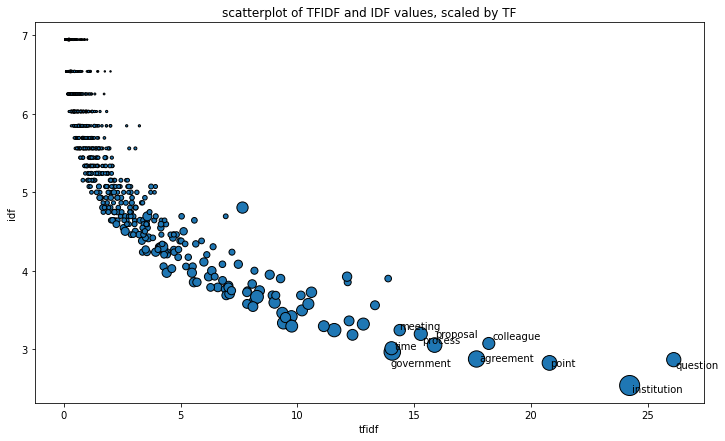

In [178]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,7))
ax.scatter(tfidf, idf, s=tf, edgecolors='black', label='tfidf')
#ax.legend()
ax.set_xlabel('tfidf')
ax.set_ylabel('idf')
ax.set_title('scatterplot of TFIDF and IDF values, scaled by TF')

# annotate words with highest tfidf
first_k = 10
sort_ix = np.argsort(tfidf)[::-1]
for ix in sort_ix[:first_k]:
    s = tfidf_vectorizer.get_feature_names()[ix].split('_')[0]
    jiggle_x = np.random.normal(0,0.1)
    jiggle_y = np.random.normal(0,0.1)
    ax.text(tfidf[ix]+jiggle_x, idf[ix]+jiggle_y, s)

# TODO: interpret the above plot

In [163]:
sort_ix = np.argsort(tfidf)[::-1]

In [156]:
np.array(tfidf_vectorizer.get_feature_names())[sort_ix][:20]

array(['question_noun', 'institution_noun', 'point_noun',
       'colleague_noun', 'agreement_noun', 'proposal_noun',
       'process_noun', 'meeting_noun', 'government_noun', 'time_noun',
       'thank_noun', '_noun', 'discussion_noun', 'course_noun',
       'day_noun', 'comment_noun', 'letter_noun', 'program_noun',
       'situation_noun', 'list_noun'], dtype='<U22')

## word embeddings
Modern embedding models define context as a local window to either
side of the target word (not whole document).
- word2vec (convention ndim=300)

two main architectures:
- **continuous bag of words** (CBOW): predict output word from input of context words (local neighbourhood)
- **skipgram**: predit cintext word output from target word input

Either used pretrained, train yourself from scratch, or transfer learning.

When training, best to train multiple models on same data and average them.

- also see doc2vec

In [112]:
df.head(20)

,speaker,speech,timestamp,date
0,Jeroen Dijsselbloem,… of your responses or questions. And can I fi...,1900-01-01 00:00:00,2015-02-24 00:00:00
1,Speaker 2,"Uh, yes, uh, thank you, Jeroen. Well, uh, comm...",1900-01-01 00:00:10,2015-02-24 00:00:00
2,Michael Noonan,Michael Noonan.,1900-01-01 00:01:27,2015-02-24 00:00:00
3,Speaker 2,"Uh, it is therefore regrettable that, uh-",1900-01-01 00:01:29,2015-02-24 00:00:00
4,Speaker 3,Has entered the conference.,1900-01-01 00:01:33,2015-02-24 00:00:00
5,Speaker 2,"… that the letter by the Minister does not, uh...",1900-01-01 00:01:37,2015-02-24 00:00:00
6,Speaker 2,"Uh, Any policy initiatives therefore, should b...",1900-01-01 00:02:48,2015-02-24 00:00:00
7,Pierre Moscovici,"Um, okay colleagues. Um, in general I would sa...",1900-01-01 00:02:59,2015-02-24 00:00:00
8,Pierre Moscovici,"In other areas, urgent and deferential, uh, in-",1900-01-01 00:03:54,2015-02-24 00:00:00
9,Speaker 3,Has entered the conference.,1900-01-01 00:04:00,2015-02-24 00:00:00


In [ ]:
#df.groupby('speaker', 'date')

# communiques

In [70]:
pd.read_csv('data/communiques/prepared.csv').sort_values(by='date').reset_index(drop=True)

,date,title,story
0,2015-02-12,Remarks by Jeroen Dijsselbloem at the press co...,"Good evening.\nToday, as you well know, we had..."
1,2015-02-16,Remarks by Jeroen Dijsselbloem at the press co...,Good evening everyone and thanks for joining t...
2,2015-02-20,Eurogroup statement on Greece,The Eurogroup reiterates its appreciation for ...
3,2015-02-20,Remarks by Jeroen Dijsselbloem at the press co...,Good evening and welcome to this press confere...
4,2015-02-24,Eurogroup statement on Greece,The Eurogroup today discussed the first list o...
5,2015-04-24,Remarks by Jeroen Dijsselbloem at the press co...,Good afternoon and welcome to this press confe...
6,2015-05-11,Eurogroup statement on Greece,The Eurogroup today took stock of the state of...
7,2015-05-11,Remarks by Jeroen Dijsselbloem at the press co...,Good evening and welcome to this press confere...
8,2015-06-18,Press remarks by Eurogroup President following...,Good evening. We can start this press conferen...
9,2015-06-22,Press remarks by Eurogroup President Jeroen Di...,Good afternoon everyone. This will be a very s...
